In [94]:
import numpy as np
import skimage.io 
import skimage.exposure as skie
from sklearn import preprocessing
import matplotlib.pyplot as plt 
import os, sys
import pickle
import pandas as pd 
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity


feature_folder = 'Y:\coskun-lab\Thomas\HTI\data\features'


In [95]:
######
experiment = 'VERO-1'
######

## Read csv file 
df_cell = pd.read_csv(os.path.join(feature_folder, experiment + '_cell.csv'), index_col = ['condition'])
df_nuclei = pd.read_csv(os.path.join(feature_folder, experiment + '_nuclei.csv'), index_col = ['condition'])

# Check if both dataframe index are the same
assert df_cell.index.equals(df_nuclei.index)

In [96]:
df_cell = df_cell.add_prefix('Cell ')
df_nuclei = df_nuclei.add_prefix('Nuclei ')

df = pd.concat([df_cell, df_nuclei], axis=1)

x = df.values #returns a numpy array
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)
df_normalized = pd.DataFrame(x_scaled, index= df.index, columns = df.columns)
df_normalized

,Cell area,Cell convex_area,Cell eccentricity,Cell equivalent_diameter,Cell extent,Cell major_axis_length,Cell minor_axis_length,Cell orientation,Cell perimeter,Cell solidity,...,Nuclei perimeter,Nuclei solidity,Nuclei mean_intensity_w1,Nuclei max_intensity_w1,Nuclei min_intensity_w1,Nuclei 1,Nuclei 2,Nuclei 3,Nuclei 4,Nuclei 5
condition,,,,,,,,,,,,,,,,,,,,,
1-deoxygalactonojirimycin 0.003,0.204324,0.193784,-0.014737,0.218508,-0.069997,0.111962,0.339803,1.476967,0.170323,-0.091944,...,0.416920,0.041115,0.182894,-0.167459,0.307553,0.112194,-0.689207,0.391045,0.546617,-0.303352
1-deoxygalactonojirimycin 0.01,0.003250,-0.004265,0.076930,0.025289,-0.005786,0.070303,-0.021783,-0.920551,0.047223,-0.071513,...,0.536378,-0.126525,0.384912,0.114375,0.343593,0.392739,-0.673480,-1.039332,0.278027,1.820435
1-deoxygalactonojirimycin 0.03,0.133821,0.155612,0.505788,0.159190,-0.533233,0.355932,-0.107979,-1.636496,0.270776,-0.512686,...,-0.058089,-0.153845,-0.131969,-0.197473,0.194089,-0.078048,-0.159747,-0.221911,0.634695,0.638228
1-deoxygalactonojirimycin 0.1,-0.051151,-0.070679,-0.094971,-0.018348,-0.005508,-0.127808,0.106867,1.114178,-0.082142,0.029154,...,0.517113,-0.061113,0.588014,0.260193,0.319063,0.096157,-0.658357,-0.513703,0.360266,2.039790
1-deoxygalactonojirimycin 0.3,-0.383222,-0.380973,-0.001168,-0.308480,0.044008,-0.313778,-0.300354,-0.474998,-0.310525,-0.043005,...,-0.160018,0.109726,0.277272,-0.024734,0.401480,-0.260438,0.159109,0.847512,-0.888735,-0.000854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
solithromycin 0.1,-0.071710,-0.067847,0.313704,-0.032957,-0.216297,0.109125,-0.235688,0.253903,0.028989,-0.219045,...,-0.175219,0.049444,0.419404,0.169694,0.126125,1.059504,-1.651400,-1.228415,-0.258245,1.924617
solithromycin 0.3,0.119836,0.100232,0.318312,0.190976,-0.445252,0.231165,0.053015,0.380710,0.190656,0.076315,...,0.220837,-0.067315,-0.077752,-0.301847,0.176334,-0.782573,0.636322,0.598138,0.961161,-0.018512
solithromycin 1.0,0.447575,0.435395,0.418890,0.434526,-0.307148,0.463491,0.295656,-1.182379,0.441627,-0.348671,...,0.409720,-0.289600,0.200413,-0.057120,0.172935,-0.719582,0.774159,-0.004993,0.922968,0.736038


In [97]:
# Utility function to get the top k most similar from disease condition, treatment and treatment concentration
def get_top_k_similar(df_corr, k=10, condition = 'Mock'):
    # Get the row in the correlation matrix
    row = df_corr.query('condition == @condition')
    # # Drop the self correlation of 1
    # row.drop(columns = row.index[0], inplace=True)
    # rename index
    corr_col = pd.DataFrame(row.T.values, index = row.T.index, columns = ['correlation'])
    # Sort by correaltion coefficient 
    corr_col.sort_values(by='correlation', inplace=True, ascending = False)

    return corr_col.head(k).to_dict()['correlation']

# Utility function to get the dataframe with only the subset index list passed
def df_by_index(df, index_list):
    return df.loc[index_list]

def plot_cluster(df, name='clustermap.png', show_tick_label = False, save_fig = False):
    lut = {'Mock': 'g', 'Irradiated':'b', 'No treatment':'r'}

    g0 = sns.clustermap(df,cmap="YlGnBu");

    mask = np.diag(np.diag(np.ones_like(df, dtype=np.bool)))
    mask = mask[np.argsort(g0.dendrogram_row.reordered_ind),:]
    mask = mask[:,np.argsort(g0.dendrogram_col.reordered_ind)]

    g = sns.clustermap(df, mask=mask, cmap="RdBu_r")
    g.fig.set_size_inches(15,15)

    if show_tick_label == False:
        g.ax_heatmap.axes.set_yticklabels('')
        g.ax_heatmap.axes.set_xticklabels('')
    else:
        color_dict = {}
        for ele in df.index:
            if ele in lut.keys():
                color_dict[ele] = lut[ele]
            else:
                color_dict[ele] = 'k'
        row_colors = pd.Series(color_dict)
        for tick_label in g.ax_heatmap.axes.get_yticklabels():
            tick_text = tick_label.get_text()
            color = color_dict[tick_text]
            tick_label.set_color(color)
        for tick_label in g.ax_heatmap.axes.get_xticklabels():
            tick_text = tick_label.get_text()
            color = color_dict[tick_text]
            tick_label.set_color(color)
        g.ax_heatmap.axes.set_xticklabels(g.ax_heatmap.axes.get_xmajorticklabels(), horizontalalignment='right', rotation=45)
    if save_fig == True:
        g.savefig(name, dpi = 300)

def plot_heatmap(df_hm, name='clustermap.png', save_fig = False):
    """
    Given a dataframe containing similarity grid, plot the heatmap
    """
    sns.set(style="white")
    
    # Set up the matplotlib figure
    # (to enlarge the cells, increase the figure size)
    f, ax = plt.subplots(figsize=(18, 18))
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(df_hm, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # Draw the heatmap with the mask and correct aspect ratio
    g = sns.heatmap(df_hm, mask=mask, cmap=cmap,
            square=True, linewidths=.5, fmt='.2f', 
            annot=False, cbar_kws={"shrink": .5}, vmax=1)
    g.set_xticklabels(g.get_xmajorticklabels(), horizontalalignment='right', rotation=45)
    ax.set_xlabel("")
    ax.set_ylabel("")
    
    if save_fig == True:
        fig = g.get_figure()
        fig.savefig(name, dpi = 100)

In [98]:
# get correlation matrix between row 
df_corr = df_normalized.T.corr()
# result = cosine_similarity(df)
# df_corr = pd.DataFrame(result, columns=df_corr.index.values, index=df_corr.index)

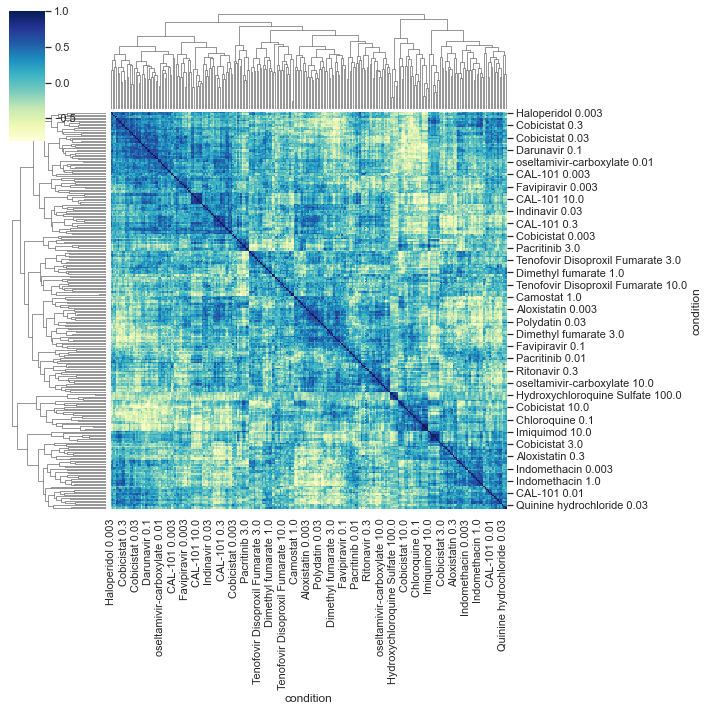

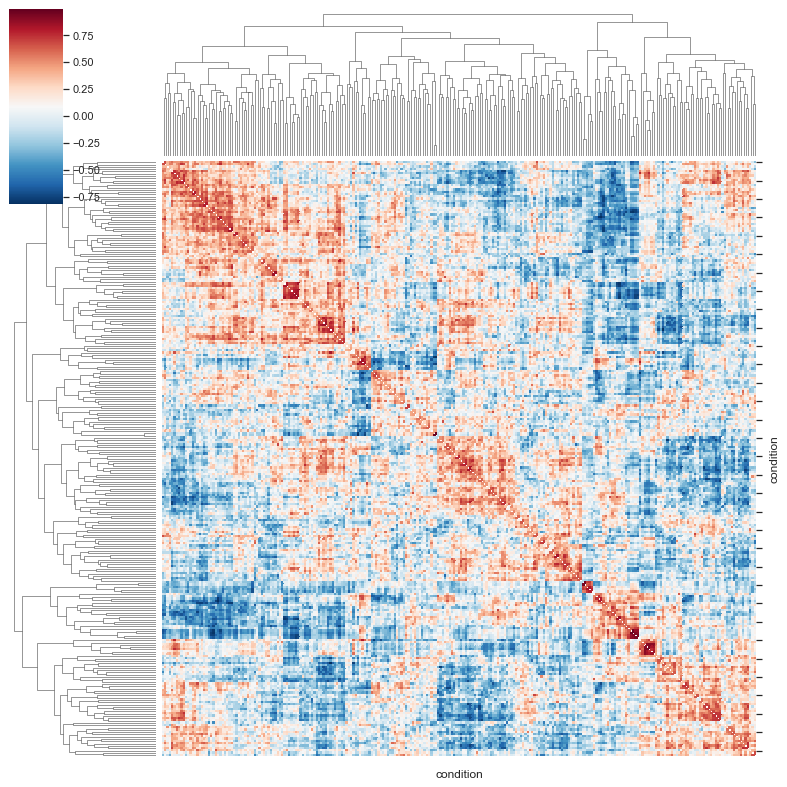

In [99]:
plot_cluster(df_corr, name=experiment+'_all.png' ,save_fig=True)

{'Mock': 1.0, 'GS-441524 10.0': 0.9400679749114081, 'Irradiated': 0.9157224035004673, 'Remdesivir (GS-5734) 10.0': 0.8071509107459727, 'solithromycin 3.0': 0.7641113540763912, 'GS-441524 3.0': 0.7535895863357522, 'Imiquimod 10.0': 0.7196487288380152, '1-deoxygalactonojirimycin 1.0': 0.661213934948961, 'GS-441524 0.3': 0.6360782049239418, 'Chloroquine 0.3': 0.6289996330073162, 'Remdesivir (GS-5734) 3.0': 0.610772761989062, 'solithromycin 10.0': 0.5660246103201073, 'quinine-ethyl-carbonate 0.01': 0.5545485464381895, 'Chloroquine 3.0': 0.5229689712934628, 'oseltamivir-carboxylate 0.003': 0.5012735593627236, 'Indinavir 0.1': 0.4979757033439804, 'Arbidol 10.0': 0.4798763764500775, 'GS-441524 0.03': 0.47932681685899736, 'GS-441524 1.0': 0.46815085985473215, 'oseltamivir-carboxylate 1.0': 0.45266959795785855, 'quinine-ethyl-carbonate 3.0': 0.44051735733471115, 'Tenofovir Disoproxil Fumarate 0.3': 0.43735355555258587, 'Polydatin 0.003': 0.43590246388146586, 'Lopinavir 10.0': 0.4289127174746130

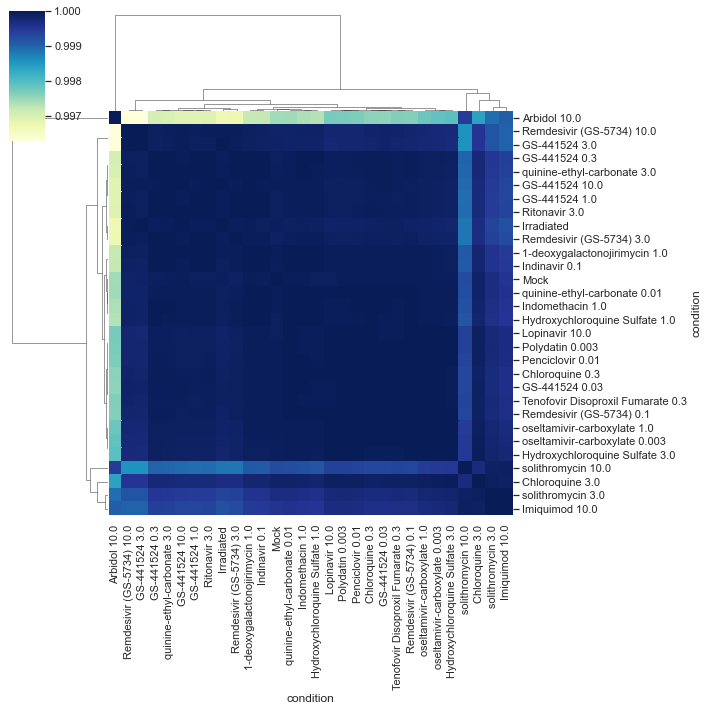

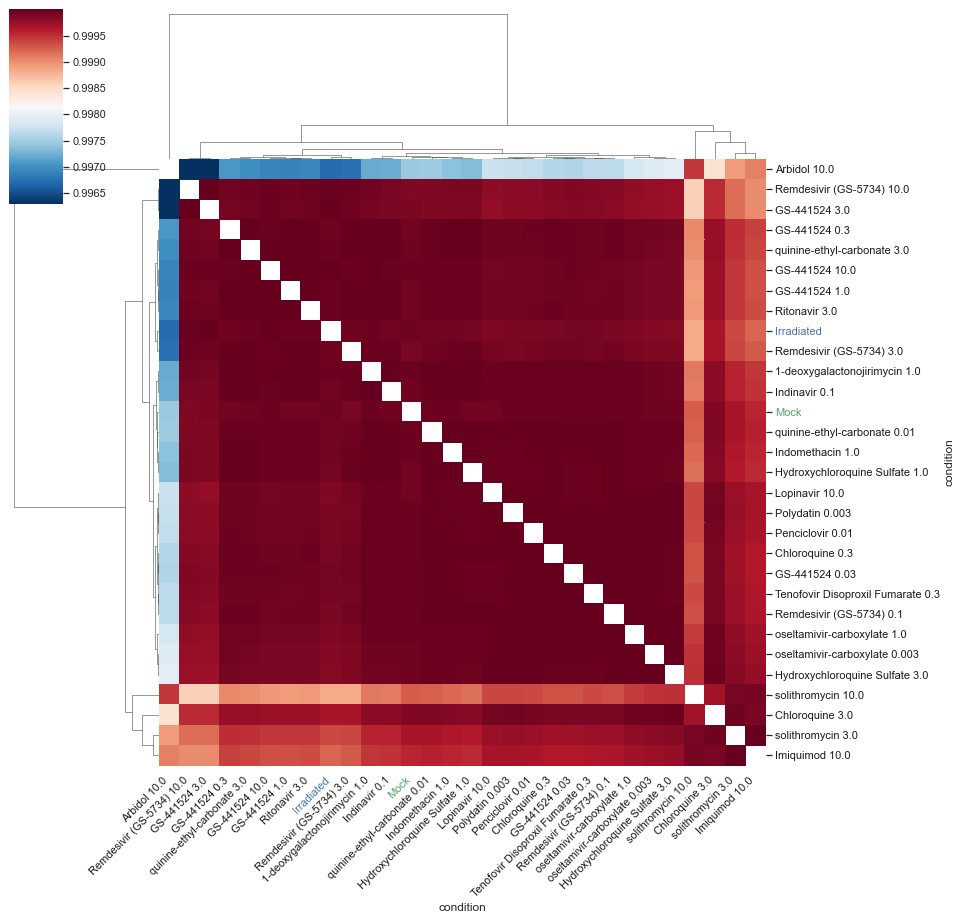

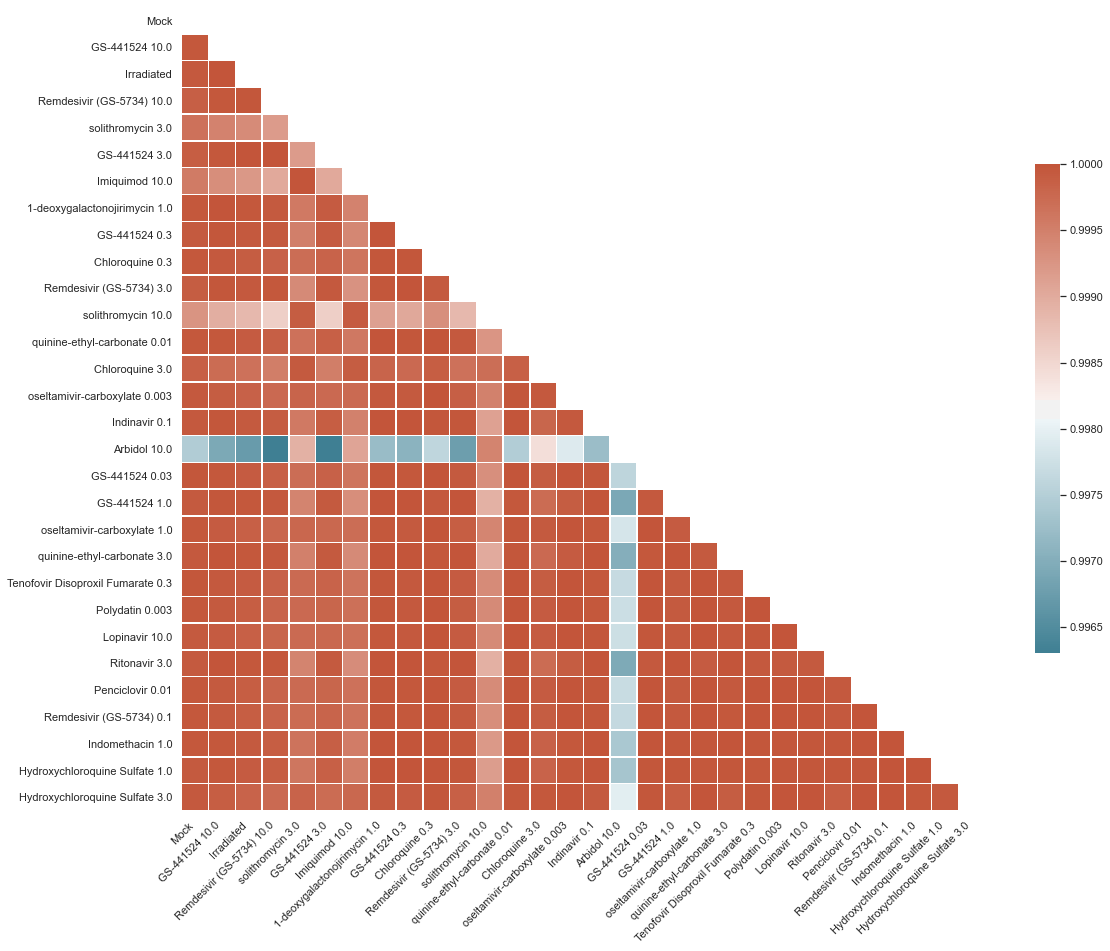

In [100]:
top_mock = get_top_k_similar(df_corr, k = 30)
df_top = df_by_index(df, list(top_mock.keys()))

print(top_mock)
plot_cluster(df_top.T.corr(), name=experiment+'_top_Mock.png', show_tick_label=True,save_fig=True)
plot_heatmap(df_top.T.corr(), name=experiment+'_top_Mock_hm.png', save_fig=True)

{'Irradiated': 1.0, 'Mock': 0.9157224035004673, 'GS-441524 3.0': 0.9050876578915521, 'GS-441524 10.0': 0.903176121328463, 'Remdesivir (GS-5734) 10.0': 0.9027054540565915, 'Remdesivir (GS-5734) 3.0': 0.6391571854058368, '1-deoxygalactonojirimycin 1.0': 0.6207446256630034, 'solithromycin 3.0': 0.599075051275696, 'Imiquimod 10.0': 0.5371001519942878, 'GS-441524 1.0': 0.5345605661647905, 'Chloroquine 0.3': 0.5326541542196735, 'Tenofovir Disoproxil Fumarate 0.3': 0.49989138306035946, 'Polydatin 0.003': 0.481559734011369, 'solithromycin 10.0': 0.48097817228498935, 'Chloroquine 3.0': 0.47913109983713326, 'GS-441524 0.3': 0.4664378480670012, 'oseltamivir-carboxylate 1.0': 0.4235787889707831, 'Lopinavir 10.0': 0.4106103378765372, 'Ritonavir 3.0': 0.3908050757934334, 'quinine-ethyl-carbonate 0.01': 0.3878276895514113, 'Penciclovir 0.01': 0.3811087392140811, 'Indinavir 0.1': 0.3769346867235257, 'GS-441524 0.03': 0.3761666702182726, 'quinine-ethyl-carbonate 0.3': 0.3751993491917081, 'Remdesivir (G

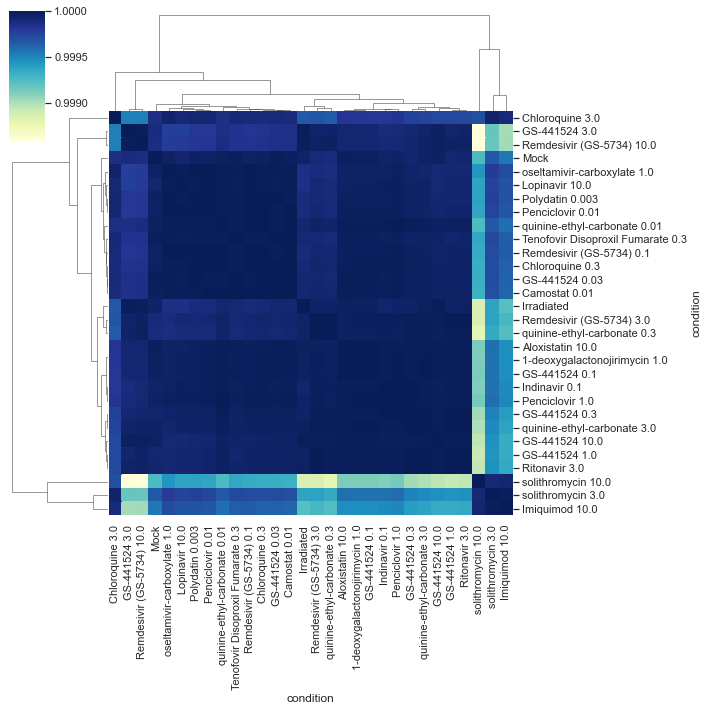

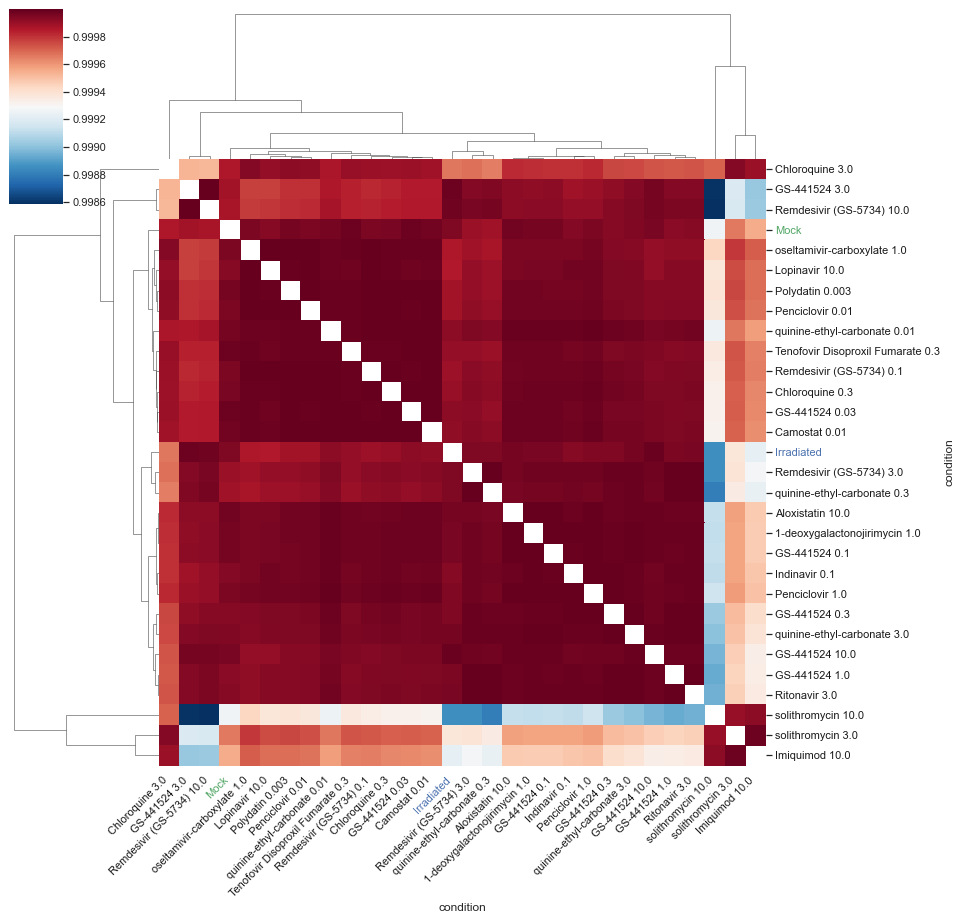

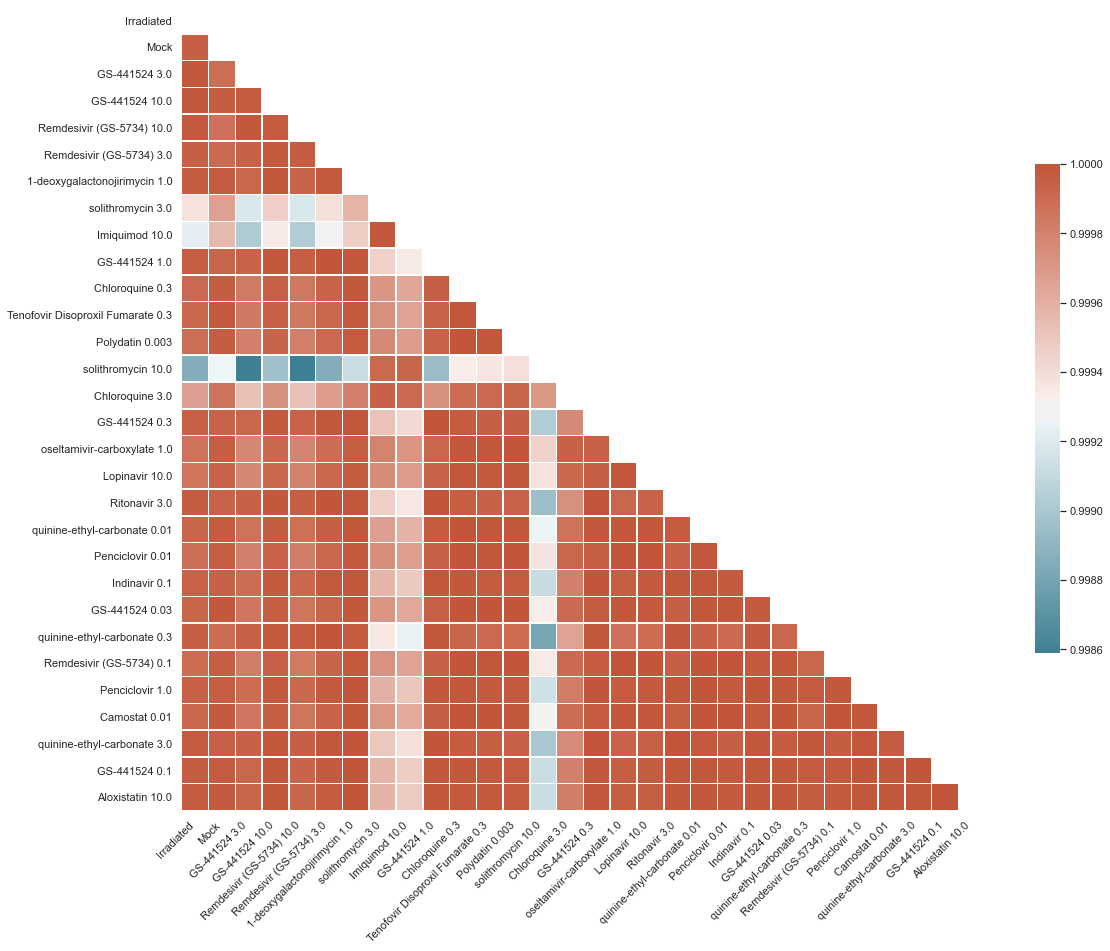

In [101]:
top_irr = get_top_k_similar(df_corr, condition = 'Irradiated', k = 30)
df_top = df_by_index(df, list(top_irr.keys()))
print(top_irr)
plot_cluster(df_top.T.corr(), name=experiment+'_top_Irr.png', show_tick_label=True,save_fig=True)
plot_heatmap(df_top.T.corr(), name=experiment+'_top_Irr_hm.png', save_fig=True)

{'No treatment': 1.0, 'Arbidol 0.01': 0.6742317164956121, 'Hydroxychloroquine Sulfate 0.03': 0.6235166515943537, 'Favipiravir 0.003': 0.595527342218665, 'Imiquimod 0.03': 0.5593871051457762, 'Nicotianamine 0.3': 0.5554315439656985, 'Camostat 1.0': 0.5507790231683418, 'Chloroquine 0.03': 0.548785673077601, 'Camostat 0.3': 0.5454316044950689, '1-deoxygalactonojirimycin 0.03': 0.5290188021418603, 'Remdesivir (GS-5734) 0.01': 0.4899110012574577, 'Indinavir 0.03': 0.4862295745176484, 'Dimethyl fumarate 0.01': 0.48506091875556145, 'Indomethacin 0.01': 0.4834123907601792, 'Polydatin 0.03': 0.4790037389512826, 'quinine-ethyl-carbonate 1.0': 0.4719177508460105, 'Lopinavir 3.0': 0.4605237884754221, 'Ribavirin 0.003': 0.4472366731603464, 'Haloperidol 0.3': 0.4352614152344974, 'Quinine hydrochloride 0.003': 0.43513261899077377, 'Dimethyl fumarate 0.003': 0.43208322650340936, 'Aloxistatin 3.0': 0.43133592056079223, 'Ritonavir 0.003': 0.42560657921629425, 'Ribavirin 0.03': 0.421763963064606, 'CAL-10

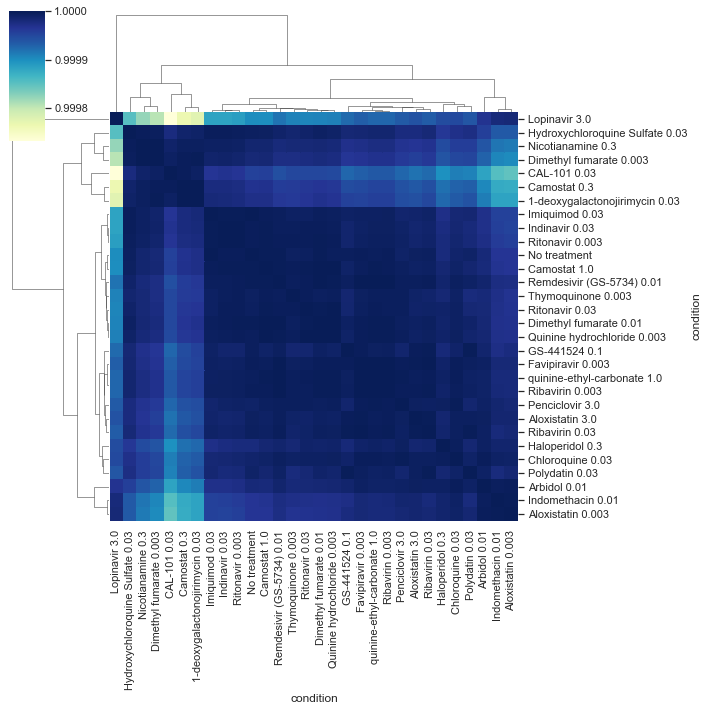

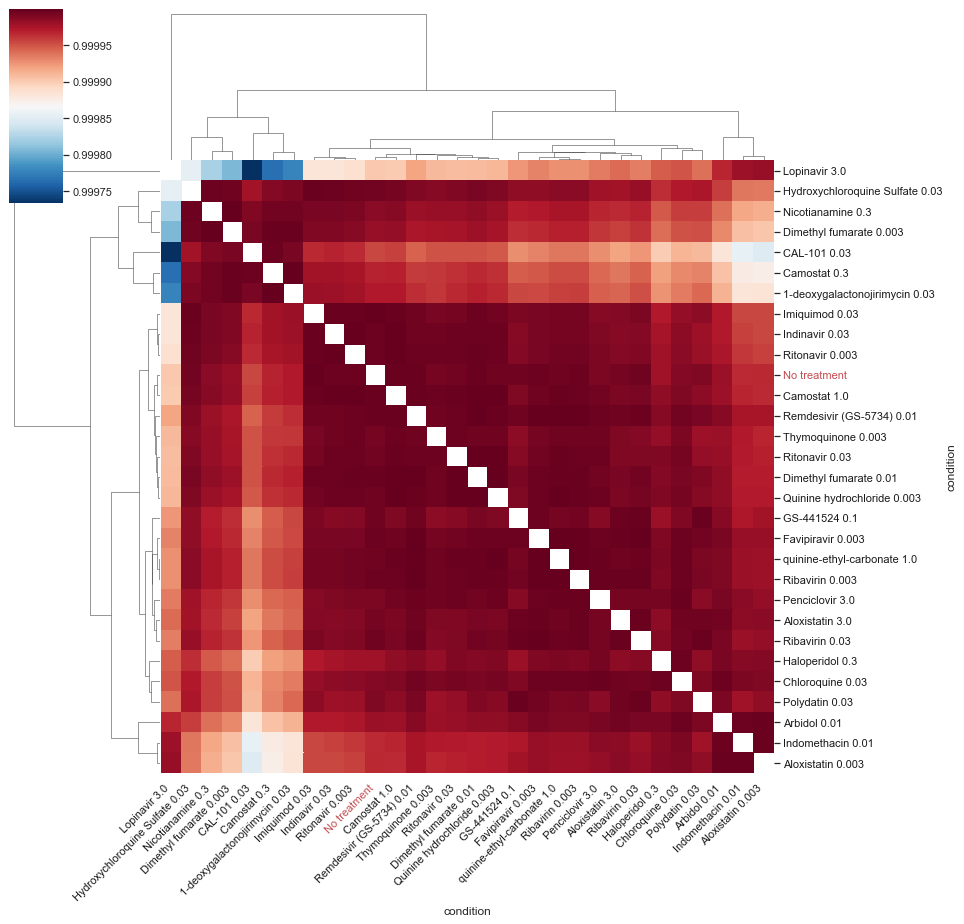

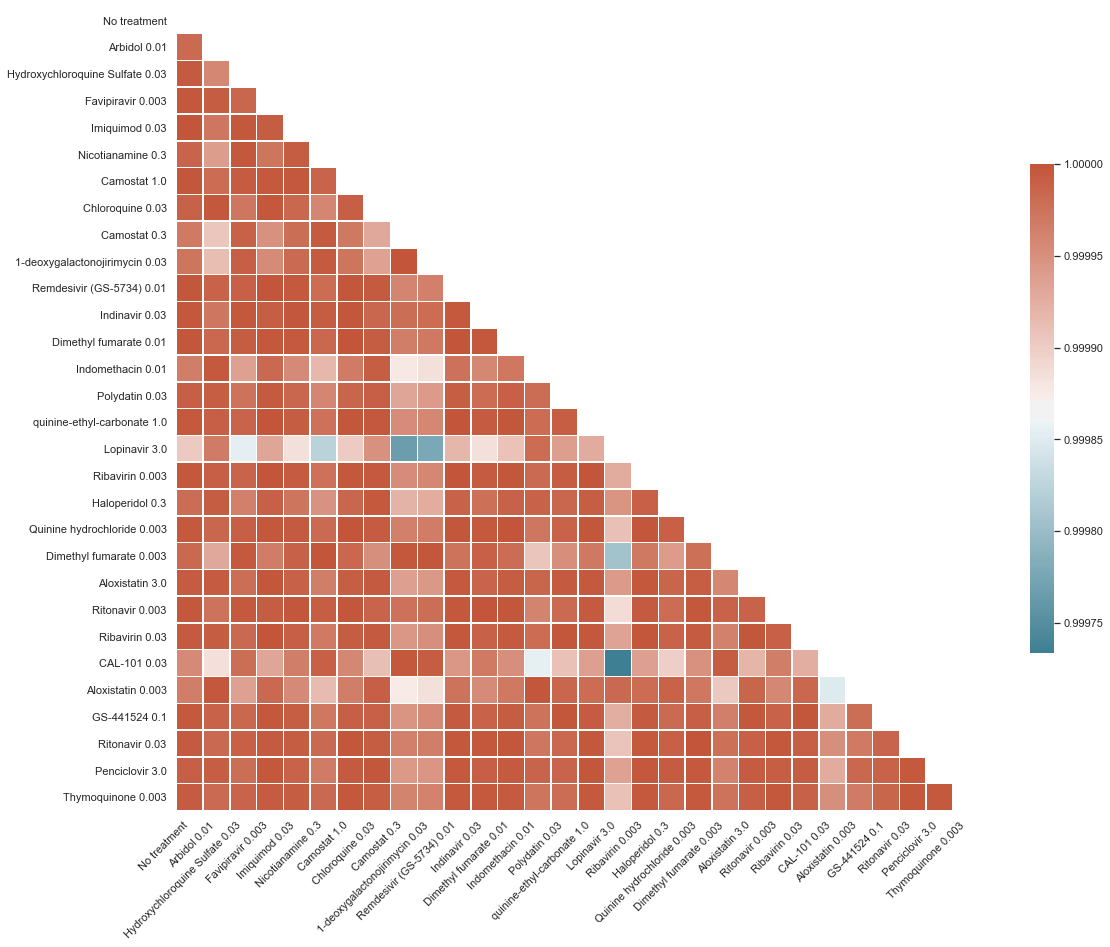

In [102]:
top_nt = get_top_k_similar(df_corr, condition = 'No treatment', k = 30)
df_top = df_by_index(df, list(top_nt.keys()))
print(top_nt)
plot_cluster(df_top.T.corr(), name=experiment+'_top_Nt.png', show_tick_label=True,save_fig=True)
plot_heatmap(df_top.T.corr(), name=experiment+'_top_Nt_hm.png', save_fig=True)